# prelim

In [1]:
import pandas as pd
import numpy as np
from os.path import join

# depending on your IDE, you might need to add datathon_eth. in front of data
from data import DataLoader, SimpleEncoding

# depending on your IDE, you might need to add datathon_eth. in front of forecast_models
from forecast_models import SimpleModel

country = "IT" 
"""

Train and evaluate the models for IT and ES

"""

# Inputs
input_path = r"datasets2025"
output_path = r"outputs"

# Load Datasets
loader = DataLoader(input_path)
# features are holidays and temperature
training_set, features, example_results = loader.load_data(country)

In [2]:
training_set

,VALUEMWHMETERINGDATA_customerIT_1,VALUEMWHMETERINGDATA_customerIT_2,VALUEMWHMETERINGDATA_customerIT_3,VALUEMWHMETERINGDATA_customerIT_4,VALUEMWHMETERINGDATA_customerIT_5,VALUEMWHMETERINGDATA_customerIT_6,VALUEMWHMETERINGDATA_customerIT_7,VALUEMWHMETERINGDATA_customerIT_8,VALUEMWHMETERINGDATA_customerIT_13,VALUEMWHMETERINGDATA_customerIT_14,...,VALUEMWHMETERINGDATA_customerIT_2832,VALUEMWHMETERINGDATA_customerIT_2836,VALUEMWHMETERINGDATA_customerIT_2844,VALUEMWHMETERINGDATA_customerIT_2845,VALUEMWHMETERINGDATA_customerIT_2847,VALUEMWHMETERINGDATA_customerIT_2848,VALUEMWHMETERINGDATA_customerIT_2849,VALUEMWHMETERINGDATA_customerIT_2850,VALUEMWHMETERINGDATA_customerIT_2851,VALUEMWHMETERINGDATA_customerIT_2852
DATETIME,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,0.061939,NaN,0.032999,0.00330,NaN,...,NaN,NaN,NaN,0.41088,0.23192,0.06751,0.01971,0.117,0.00549,NaN
2022-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,0.057222,NaN,0.076501,0.00315,NaN,...,NaN,NaN,NaN,0.39106,0.23214,0.03488,0.01943,0.105,0.00551,NaN
2022-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,0.071429,NaN,0.129450,0.00315,NaN,...,NaN,NaN,NaN,0.40334,0.23323,0.04726,0.01971,0.108,0.00552,NaN
2022-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,0.064760,NaN,0.074399,0.00330,NaN,...,NaN,NaN,NaN,0.38904,0.23188,0.05513,0.01947,0.117,0.00551,NaN
2022-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,0.071744,NaN,0.054900,0.00315,NaN,...,NaN,NaN,NaN,0.41345,0.23478,0.03601,0.01981,0.108,0.00563,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-31 19:00:00,0.001663,0.012574,0.216216,0.427020,0.013150,0.274971,0.192576,0.013650,0.00288,0.000000,...,0.0045,0.1574,0.005214,1.87474,0.03826,0.00676,0.00908,0.108,0.00072,0.01820
2024-07-31 20:00:00,0.001626,0.000676,0.212058,0.459361,0.001875,0.308020,0.168000,0.013050,0.00276,0.001499,...,0.0045,0.1484,0.005219,1.76142,0.04051,0.00788,0.00612,0.099,0.00021,0.01672
2024-07-31 21:00:00,0.001885,0.000750,0.203148,0.461340,0.001725,0.308613,0.221760,0.023700,0.00276,0.002100,...,0.0060,0.1310,0.005187,1.90682,0.03938,0.00788,0.00696,0.078,0.00016,0.01964


<Axes: xlabel='DATETIME'>

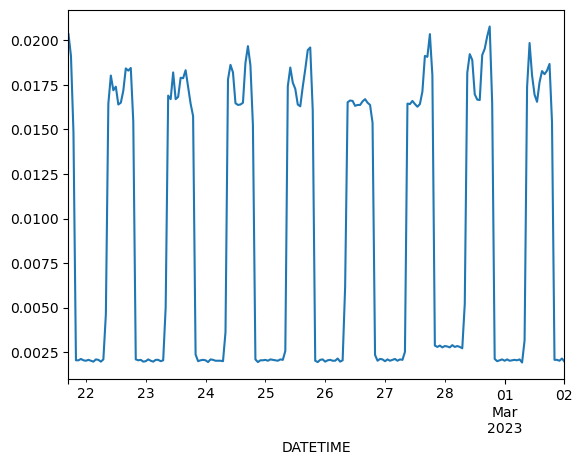

In [3]:
training_set[training_set.columns[4]][10000:10200].plot()

In [4]:
class SimpleEncoding:
    """
    This class is an example of dataset encoding.

    """

    def __init__(
        self,
        consumption: pd.Series,
        features: pd.Series,
        end_training,
        start_forecast,
        end_forecast,
    ):
        self.consumption_mask = ~consumption.isna()
        self.consumption = consumption[self.consumption_mask]
        self.features = features
        self.end_training = end_training
        self.start_forecast = start_forecast
        self.end_forecast = end_forecast

    def meta_encoding(self):
        """
        This function returns the feature, split between past (for training) and future (for forecasting)),
        as well as the consumption, without missing values.
        :return: three numpy arrays

        """
        features_past = self.features[: self.end_training].values.reshape(-1, 1)
        features_future = self.features[
            self.start_forecast : self.end_forecast
        ].values.reshape(-1, 1)

        features_past = features_past[self.consumption_mask]

        return features_past, features_future, self.consumption

In [5]:
training_set.isna().sum()

VALUEMWHMETERINGDATA_customerIT_1       13102
VALUEMWHMETERINGDATA_customerIT_2        8759
VALUEMWHMETERINGDATA_customerIT_3        6551
VALUEMWHMETERINGDATA_customerIT_4        6551
VALUEMWHMETERINGDATA_customerIT_5        8879
                                        ...  
VALUEMWHMETERINGDATA_customerIT_2848      744
VALUEMWHMETERINGDATA_customerIT_2849        0
VALUEMWHMETERINGDATA_customerIT_2850        0
VALUEMWHMETERINGDATA_customerIT_2851        0
VALUEMWHMETERINGDATA_customerIT_2852    10895
Length: 1696, dtype: int64

<Axes: xlabel='DATETIME'>

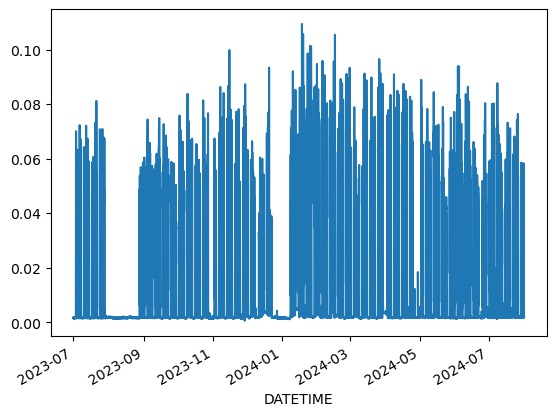

In [6]:
training_set[training_set.columns[0]].plot()

<Axes: xlabel='DATETIME'>

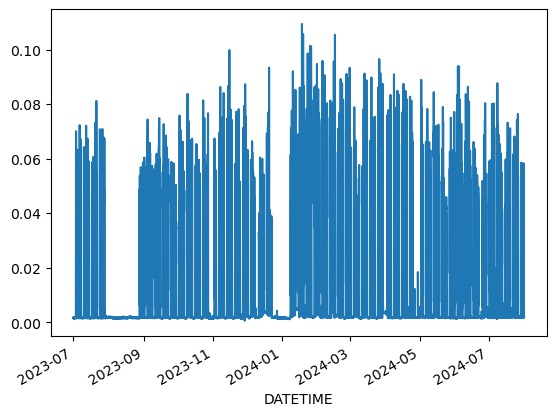

In [7]:
training_set[training_set.columns[0]].plot()

In [8]:
import pandas as pd
import numpy as np

class Encoder:
    """
    This class is an example of dataset encoding for a multivariate feature set.
    """

    def __init__(
        self,
        consumption: pd.Series,
        features: pd.DataFrame,
        end_training,
        start_forecast,
        end_forecast,
    ):
        # assert isinstance(features, pd.DataFrame), "features must be a DataFrame"
        self.consumption_mask = ~consumption.isna()
        self.consumption = consumption[self.consumption_mask]
        self.features = features
        self.end_training = end_training
        self.start_forecast = start_forecast
        self.end_forecast = end_forecast

    def meta_encoding(self):
        """
        This function returns the feature matrix split between past (for training)
        and future (for forecasting), as well as the non-missing consumption values.
        :return: (features_past, features_future, consumption) as numpy arrays
        """
        # Select past and future feature slices
        features_past = self.features.loc[:self.end_training].values
        features_future = self.features.loc[self.start_forecast:self.end_forecast].values

        # Apply the consumption mask to past features
        features_past = features_past[self.consumption_mask]

        return features_past, features_future, self.consumption.values


In [9]:
input_path = r"datasets2025"
output_path = r"outputs"

# Load Datasets
loader = DataLoader(input_path)
# features are holidays and temperature
zone = "IT" # "ES"
training_set, features, example_results = loader.load_data(zone)
start_training = training_set.index.min()
end_training = training_set.index.max()
start_forecast, end_forecast = example_results.index[0], example_results.index[-1]
consumption = training_set

feature_dummy = features['temp'].loc[start_training:]

# encoding = Encoder(
#     consumption, feature_dummy, end_training, start_forecast, end_forecast
# )

In [28]:
training_set.iloc[:, 0:5].pct_change().corr()

/tmp/ipykernel_144696/1857501378.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  training_set.iloc[:, 0:5].pct_change().corr()


,VALUEMWHMETERINGDATA_customerIT_1,VALUEMWHMETERINGDATA_customerIT_2,VALUEMWHMETERINGDATA_customerIT_3,VALUEMWHMETERINGDATA_customerIT_4,VALUEMWHMETERINGDATA_customerIT_5
VALUEMWHMETERINGDATA_customerIT_1,1.000000,-0.014497,-0.003786,-0.009756,0.052571
VALUEMWHMETERINGDATA_customerIT_2,-0.014497,1.000000,-0.001684,0.004109,0.521564
VALUEMWHMETERINGDATA_customerIT_3,-0.003786,-0.001684,1.000000,0.051858,-0.004283
VALUEMWHMETERINGDATA_customerIT_4,-0.009756,0.004109,0.051858,1.000000,-0.020768
VALUEMWHMETERINGDATA_customerIT_5,0.052571,0.521564,-0.004283,-0.020768,1.000000


<Axes: xlabel='DATETIME'>

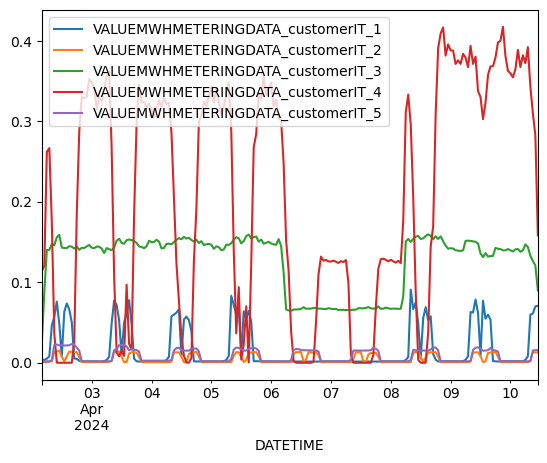

In [11]:
training_set.iloc[-2900:-2700, 0:5].plot()

In [12]:
# rollout_it = pd.read_csv("datasets2025/rollout_data_IT.csv", index_col = 0, parse_dates = True)
# rollout_it.head()

In [13]:
# customer_id = 1
# joint_df = pd.concat([rollout_it.loc[:, rollout_it.columns[customer_id]], 
#                     training_set.loc[:, training_set.columns[customer_id]]],
#                     axis = 1)
# joint_df

In [14]:
# joint_df.iloc[10800:11000].plot()

# Some ML

In [15]:
training_set

,VALUEMWHMETERINGDATA_customerIT_1,VALUEMWHMETERINGDATA_customerIT_2,VALUEMWHMETERINGDATA_customerIT_3,VALUEMWHMETERINGDATA_customerIT_4,VALUEMWHMETERINGDATA_customerIT_5,VALUEMWHMETERINGDATA_customerIT_6,VALUEMWHMETERINGDATA_customerIT_7,VALUEMWHMETERINGDATA_customerIT_8,VALUEMWHMETERINGDATA_customerIT_13,VALUEMWHMETERINGDATA_customerIT_14,...,VALUEMWHMETERINGDATA_customerIT_2832,VALUEMWHMETERINGDATA_customerIT_2836,VALUEMWHMETERINGDATA_customerIT_2844,VALUEMWHMETERINGDATA_customerIT_2845,VALUEMWHMETERINGDATA_customerIT_2847,VALUEMWHMETERINGDATA_customerIT_2848,VALUEMWHMETERINGDATA_customerIT_2849,VALUEMWHMETERINGDATA_customerIT_2850,VALUEMWHMETERINGDATA_customerIT_2851,VALUEMWHMETERINGDATA_customerIT_2852
DATETIME,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,0.061939,NaN,0.032999,0.00330,NaN,...,NaN,NaN,NaN,0.41088,0.23192,0.06751,0.01971,0.117,0.00549,NaN
2022-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,0.057222,NaN,0.076501,0.00315,NaN,...,NaN,NaN,NaN,0.39106,0.23214,0.03488,0.01943,0.105,0.00551,NaN
2022-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,0.071429,NaN,0.129450,0.00315,NaN,...,NaN,NaN,NaN,0.40334,0.23323,0.04726,0.01971,0.108,0.00552,NaN
2022-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,0.064760,NaN,0.074399,0.00330,NaN,...,NaN,NaN,NaN,0.38904,0.23188,0.05513,0.01947,0.117,0.00551,NaN
2022-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,0.071744,NaN,0.054900,0.00315,NaN,...,NaN,NaN,NaN,0.41345,0.23478,0.03601,0.01981,0.108,0.00563,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-31 19:00:00,0.001663,0.012574,0.216216,0.427020,0.013150,0.274971,0.192576,0.013650,0.00288,0.000000,...,0.0045,0.1574,0.005214,1.87474,0.03826,0.00676,0.00908,0.108,0.00072,0.01820
2024-07-31 20:00:00,0.001626,0.000676,0.212058,0.459361,0.001875,0.308020,0.168000,0.013050,0.00276,0.001499,...,0.0045,0.1484,0.005219,1.76142,0.04051,0.00788,0.00612,0.099,0.00021,0.01672
2024-07-31 21:00:00,0.001885,0.000750,0.203148,0.461340,0.001725,0.308613,0.221760,0.023700,0.00276,0.002100,...,0.0060,0.1310,0.005187,1.90682,0.03938,0.00788,0.00696,0.078,0.00016,0.01964


## Fourier Encode

In [16]:
customer = training_set.columns[0]
X = training_set[customer]

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from lightgbm import LGBMRegressor

# --------- Model Classes ---------

class BaseModel:
    def train(self, X, y):
        raise NotImplementedError

    def predict(self, X):
        raise NotImplementedError

class LightGBMModel(BaseModel):
    def __init__(self, **params):
        self.model = LGBMRegressor(**params)

    def train(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)

class LinearRegressionModel(BaseModel):
    def __init__(self, **params):
        self.model = LinearRegression(**params)

    def train(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)

# --------- Time Feature Extractor ---------

class TimeFeaturesExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Expecting X to be a DataFrame with a DatetimeIndex.
        df = pd.DataFrame(index=X.index)
        df["hour"] = X.index.hour
        df["dayofweek"] = X.index.dayofweek
        return df

# --------- Main Forecast Function ---------

def forecast_time_series(
    X: pd.Series,
    forecast_horizon: int = 720,  # forecast 720 time steps which are the test set
    model_type: str = "lightgbm",
    **model_params
):
    # Ensure the index is a DatetimeIndex and drop missing values
    if not isinstance(X.index, pd.DatetimeIndex):
        raise ValueError("The time series index must be a pandas DatetimeIndex.")
    X = X.dropna()

    # Split data into training and test sets
    if len(X) < forecast_horizon:
        raise ValueError("The time series does not have enough data for the specified forecast horizon.")
        
    train_size = len(X) - forecast_horizon
    X_train_raw = X.iloc[:train_size]
    X_test_raw = X.iloc[train_size:]
    
    y_train = X_train_raw.values
    y_test = X_test_raw.values

    # Feature pipeline: extract time features and then one-hot encode them.
    feature_extractor = Pipeline([
        ('time_features', TimeFeaturesExtractor()),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Fit the feature extractor on the training data and transform both sets
    X_train_features = feature_extractor.fit_transform(X_train_raw.to_frame())
    X_test_features = feature_extractor.transform(X_test_raw.to_frame())

    # Choose the forecasting model
    model_classes = {
        "lightgbm": LightGBMModel,
        "linear": LinearRegressionModel,
    }
    if model_type not in model_classes:
        raise ValueError(f"Unsupported model type: {model_type}. Choose from {list(model_classes.keys())}")

    model = model_classes[model_type](**model_params)
    model.train(X_train_features, y_train)

    # Predict the test set in one go
    y_pred = model.predict(X_test_features)

    # Calculate and print Mean Squared Error for the test set
    mse = np.mean(np.square(y_pred - y_test))
    print("Test MSE:", mse)

    # Plot ground truth vs. predicted values for the 720-step test set
    plt.figure(figsize=(12, 6))
    plt.plot(X_test_raw.index, y_test, label='Ground Truth', linewidth=2)
    plt.plot(X_test_raw.index, y_pred, label='Predicted', linestyle='--')
    plt.title(f"{forecast_horizon}-Step Forecast Comparison ({model_type})")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Optionally, return a DataFrame with the ground truth and predicted values
    results = pd.DataFrame({
        "Ground Truth": y_test,
        "Predicted": y_pred
    }, index=X_test_raw.index)
    
    return results

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 62
[LightGBM] [Info] Number of data points in the train set: 8807, number of used features: 31
[LightGBM] [Info] Start training from score 0.013288
Test MSE: 5.015904599236299e-05


/home/ashnvael/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


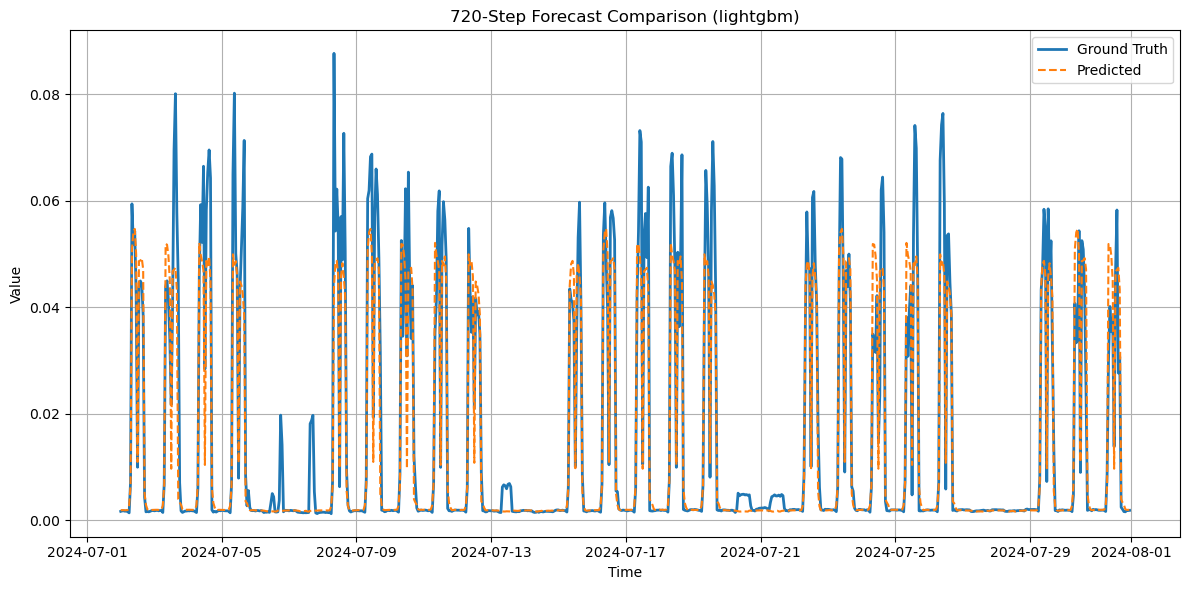

,Ground Truth,Predicted
DATETIME,,
2024-07-02 00:00:00,0.001700,0.001919
2024-07-02 01:00:00,0.001784,0.001935
2024-07-02 02:00:00,0.001811,0.001925
2024-07-02 03:00:00,0.001737,0.001916
2024-07-02 04:00:00,0.001769,0.001916
...,...,...
2024-07-31 19:00:00,0.001663,0.002922
2024-07-31 20:00:00,0.001626,0.002099
2024-07-31 21:00:00,0.001885,0.001984


In [25]:
forecast_time_series(X, 720, model_type="lightgbm")

Test MSE: 0.0001463800716460034


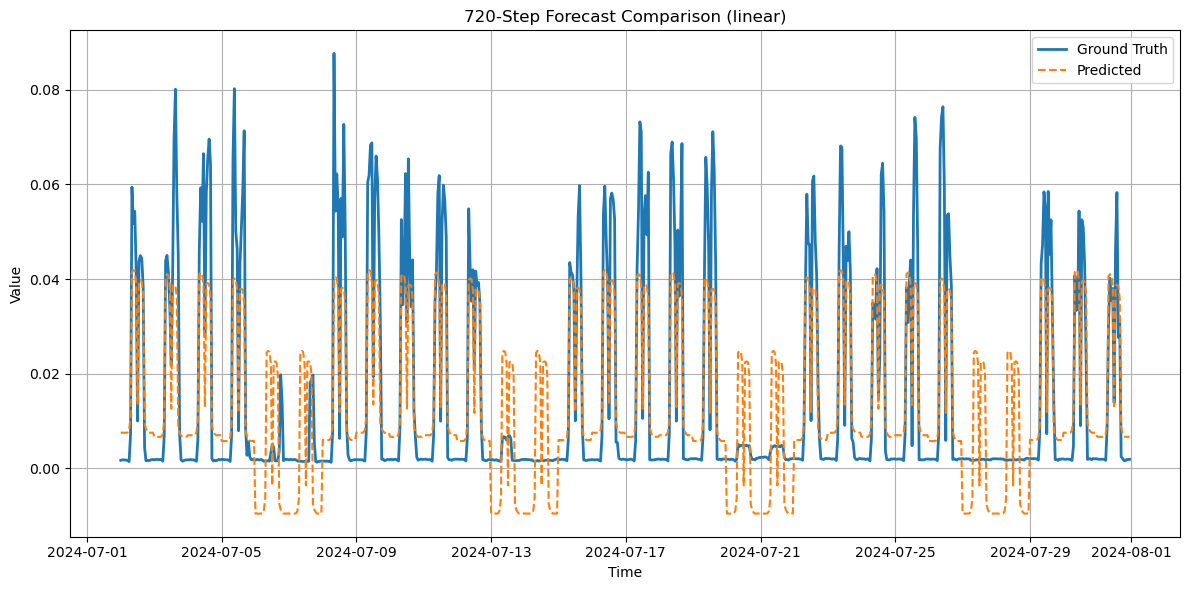

,Ground Truth,Predicted
DATETIME,,
2024-07-02 00:00:00,0.001700,0.007543
2024-07-02 01:00:00,0.001784,0.007544
2024-07-02 02:00:00,0.001811,0.007503
2024-07-02 03:00:00,0.001737,0.007531
2024-07-02 04:00:00,0.001769,0.007530
...,...,...
2024-07-31 19:00:00,0.001663,0.006929
2024-07-31 20:00:00,0.001626,0.006642
2024-07-31 21:00:00,0.001885,0.006643


In [26]:
forecast_time_series(X, 720, model_type="linear")

## RBF Encode

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000048 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 62
[LightGBM] [Info] Number of data points in the train set: 7622, number of used features: 31
[LightGBM] [Info] Start training from score 0.013171
MSE: 8.992649490379685e-05


/home/ashnvael/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


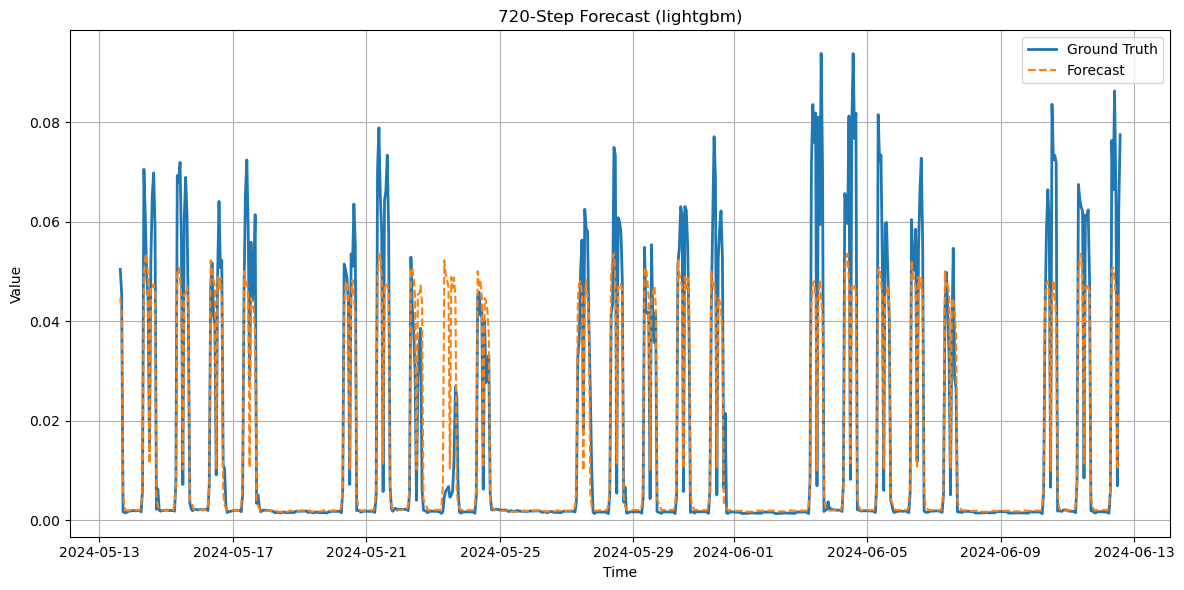

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from lightgbm import LGBMRegressor


# --------- Model Classes ---------

class BaseModel:
    def train(self, X, y):
        raise NotImplementedError

    def predict(self, X):
        raise NotImplementedError


class LightGBMModel(BaseModel):
    def __init__(self, **params):
        self.model = LGBMRegressor(**params)

    def train(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)


class LinearRegressionModel(BaseModel):
    def __init__(self, **params):
        self.model = LinearRegression(**params)

    def train(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)


# --------- Time Feature Extractor ---------

class TimeFeaturesExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df = pd.DataFrame(index=X.index)
        df["hour"] = X.index.hour
        df["dayofweek"] = X.index.dayofweek
        return df


# --------- Main Forecast Function ---------

def forecast_time_series(
    X: pd.Series,
    forecast_horizon: int = 240,
    test_frac: float = 0.2,
    model_type: str = "lightgbm",
    **model_params
):
    # Drop missing values
    X = X.dropna()

    # Ensure enough data for test
    total_len = len(X)
    test_size = max(int(total_len * test_frac), forecast_horizon)
    train_size = total_len - test_size

    X_train_raw = X.iloc[:train_size]
    X_test_raw = X.iloc[train_size:train_size + forecast_horizon]
    y_train = X_train_raw.values
    y_test = X_test_raw.values

    # Feature pipeline
    feature_extractor = Pipeline([
        ('time_features', TimeFeaturesExtractor()),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ])

    X_train_features = feature_extractor.fit_transform(X_train_raw.to_frame())
    X_test_features = feature_extractor.transform(X_test_raw.to_frame())

    # Choose model
    model_classes = {
        "lightgbm": LightGBMModel,
        "linear": LinearRegressionModel,
    }

    if model_type not in model_classes:
        raise ValueError(f"Unsupported model type: {model_type}. Choose from {list(model_classes.keys())}")

    model = model_classes[model_type](**model_params)
    model.train(X_train_features, y_train)
    y_pred = model.predict(X_test_features)

    print("MSE:", np.mean(np.square(y_pred - y_test)))

    # Plot predictions
    plt.figure(figsize=(12, 6))
    plt.plot(X_test_raw.index, y_test, label='Ground Truth', linewidth=2)
    plt.plot(X_test_raw.index, y_pred, label='Forecast', linestyle='--')
    plt.title(f"{forecast_horizon}-Step Forecast ({model_type})")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# LightGBM
forecast_time_series(X, model_type="lightgbm", forecast_horizon=720, n_estimators=100, learning_rate=0.05)

MSE: 0.00020705065513767996


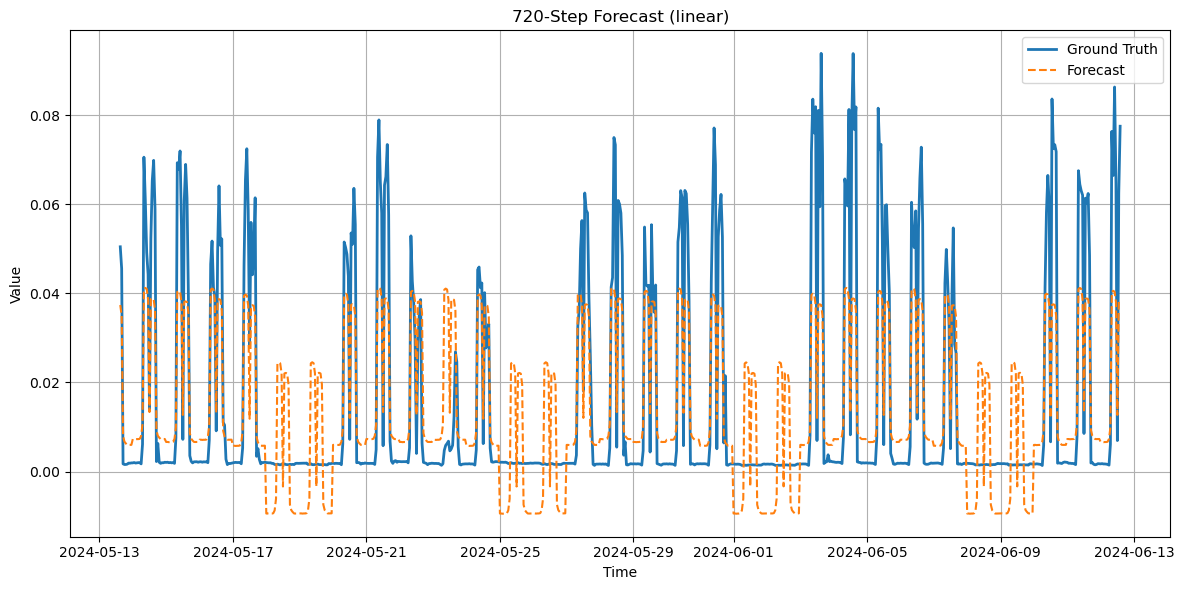

In [21]:
forecast_time_series(X, model_type="linear", forecast_horizon=720)

# Baseline Prediction

In [1]:
import pandas as pd
import numpy as np
from os.path import join

# depending on your IDE, you might need to add datathon_eth. in front of data
from data import DataLoader, SimpleEncoding

# depending on your IDE, you might need to add datathon_eth. in front of forecast_models
from forecast_models import SimpleModel

country = "ES" 
"""

Train and evaluate the models for IT and ES

"""

# Inputs
input_path = r"datasets2025"
output_path = r"outputs"

# Load Datasets
loader = DataLoader(input_path)
# features are holidays and temperature
training_set, features, example_results = loader.load_data(country)
rollout, holidays = loader.load_additional_data(country)

In [2]:
from data import DataLoader, DatasetEncoding

team_name = "HANGUK_ML"
# Data Manipulation and Training
start_training = training_set.index.min()
end_training = training_set.index.max()
start_forecast, end_forecast = example_results.index[0], example_results.index[-1]

range_forecast = pd.date_range(start=start_forecast, end=end_forecast, freq="1H")

de = DatasetEncoding(
    consumption=training_set,
    features=features,
    rollout=rollout,
    holiday=holidays,
    end_training=end_training,
    start_forecast=start_forecast,
    end_forecast=end_forecast,
)
df = de.generate_time_series_features(
    start_time=start_training,
    end_time=end_training,
)

/tmp/ipykernel_10712/2960689831.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  range_forecast = pd.date_range(start=start_forecast, end=end_forecast, freq="1H")


In [3]:
df = de.generate_dataset(customer_id=1, window_size=24 * 7, forecast_skip=1, forecast_horizon=7)
df_train = df[:-737]
df_test = df[-737:]

## naive1

/home/ashnvael/data-workspace/baseline_models.py:52: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  prediction_range = pd.date_range(start=prediction_start, periods=self.prediction_window, freq='H')


Current observation: 2024-06-30 23:00:00
Prediction range starts at: 2024-07-01 00:00:00
Candidate range (1 year ago) starts at: 2023-07-01 00:00:00
Candidate range (1 month ago) starts at: 2024-06-01 00:00:00


<Axes: >

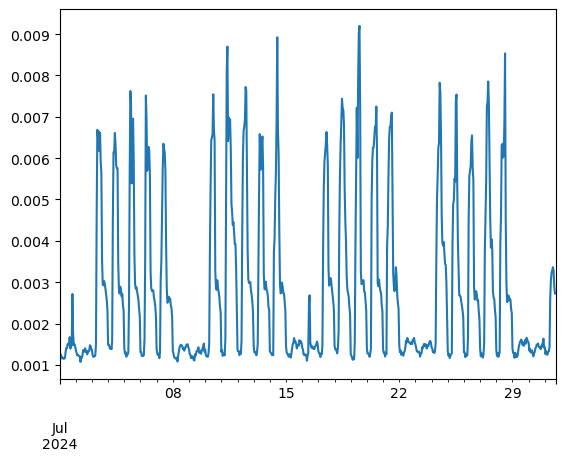

In [4]:
from baseline_models import naive

model_naive = naive(prediction_window=737)
pred = model_naive.predict(df_train)
pred.plot()

MSE =  9.302037150610584e-06


<Axes: >

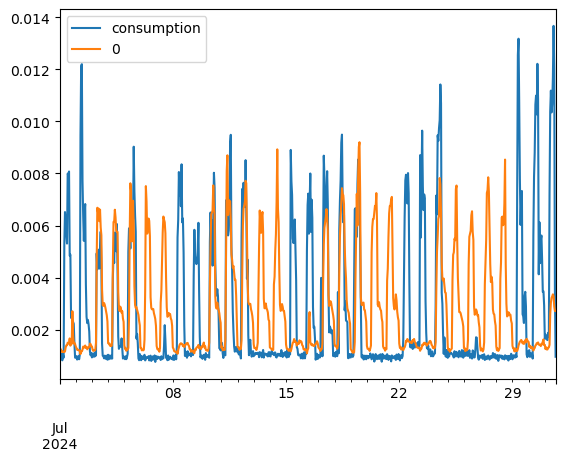

In [5]:
joint_df = pd.concat([df_test["consumption"], pred], axis = 1)
print("MSE = ", np.mean(np.square(df_test["consumption"] - pred)))
joint_df.plot()

## naive2

In [6]:
from baseline_models import naive2

model_naive = naive2(prediction_window=737)
model_naive.train(df_train)
pred = model_naive.predict(df_train)
pred.plot()

Baseline computed for (dayofweek, hour) pairs.


/home/ashnvael/data-workspace/baseline_models.py:146: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  prediction_range = pd.date_range(start=prediction_start, periods=self.prediction_window, freq='H')


ValueError: cannot reindex on an axis with duplicate labels

In [ ]:
joint_df = pd.concat([df_test["consumption"], pred], axis = 1)
print("MSE = ", np.mean(np.square(df_test["consumption"] - pred)))
joint_df.plot()

In [ ]:
joint_df = pd.concat([df_test["consumption"], pred], axis = 1)
print("MSE = ", np.mean(np.square(df_test["consumption"] - pred)))
joint_df.plot()

## naive_3

In [ ]:
class plain:

    def __init__(self, prediction_window: int = 720):
        # prediction_window is the number of future hourly time steps to forecast.
        self.prediction_window = prediction_window

    def train(self, **kwargs):
        # No training is needed for a naive predictor.
        pass

    def predict(self, x: pd.Series) -> pd.Series:
        """
        Predict the next prediction_window timesteps after the last index in x.

        The procedure is:
          - Define a prediction range: hourly timestamps starting from the next midnight after
            the last observation.
          - Candidate one: lookup the corresponding period one year ago.
          - Candidate two: lookup the corresponding period one month ago.
          - For each timestep in the prediction range, if both candidate values are available,
            take their average; if only one is available, use that value; if both are missing,
            return 0.
        
        Parameters:
          x (pd.Series): Time series with a DatetimeIndex.
        
        Returns:
          pd.Series: Forecasted values for the next prediction_window hours, with the future timestamps.
        """
        # Ensure x has a DatetimeIndex
        if not isinstance(x.index, pd.DatetimeIndex):
            raise ValueError("Input time series must have a DatetimeIndex.")

        x = x['consumption']

        # Determine the current observation (last timestamp)
        current_observation = x.index[-1]
        # Determine the next day’s midnight:
        prediction_start = (current_observation + pd.Timedelta(days=1)).normalize()
        # Create the prediction range with hourly frequency
        prediction_range = pd.date_range(start=prediction_start, periods=self.prediction_window, freq='H')

        candidate_range_year = prediction_range - DateOffset(years=1)
        candidate_range_month = prediction_range - DateOffset(months=1)

        candidate_one = x.reindex(candidate_range_year)
        candidate_one.index = prediction_range  # Carry candidate values into the future index

        candidate_two = x.reindex(candidate_range_month)
        candidate_two.index = prediction_range  # Carry candidate values into the future index
        
        df_candidates = pd.DataFrame({
            "candidate_one": candidate_one,
            "candidate_two": candidate_two
        }, index=prediction_range)

        forecast = df_candidates.mean(axis=1, skipna=True)
        forecast = forecast.fillna(0)

        # Debug prints (optional)
        print("Current observation:", current_observation)
        print("Prediction range starts at:", prediction_range[0])
        print("Candidate range (1 year ago) starts at:", candidate_range_year[0])
        print("Candidate range (1 month ago) starts at:", candidate_range_month[0])

        return forecast